<a href="https://colab.research.google.com/github/Dhruv-158/Human-Activity-Recognition-System/blob/main/Human_Activity_Recognition_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ============================================
# 1. Install libraries (if needed in Colab)
# ============================================
!pip install seaborn joblib tensorflow

In [2]:
# ============================================
# 2. Imports
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint, uniform

import tensorflow as tf
from tensorflow.keras import layers, models

import joblib


In [3]:
# ============================================
# 3. Upload and extract dataset (UCI HAR ZIP)
# ============================================
from google.colab import files
uploaded = files.upload()   # upload: "UCI HAR Dataset.zip"

import zipfile, os

zip_path = list(uploaded.keys())[0]  # take first uploaded file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('.')

print("Extracted folders:", os.listdir('.'))


Saving human+activity+recognition+using+smartphones.zip to human+activity+recognition+using+smartphones (1).zip
Extracted folders: ['.config', 'human+activity+recognition+using+smartphones (1).zip', 'UCI HAR Dataset.names', 'UCI HAR Dataset.zip', 'human+activity+recognition+using+smartphones.zip', 'sample_data']


In [10]:
import zipfile
import os

zip_path = "/content/UCI HAR Dataset.zip"  # Exact file name from your list

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/")

os.listdir("/content/")


['.config',
 '__MACOSX',
 'human+activity+recognition+using+smartphones (1).zip',
 'UCI HAR Dataset',
 'UCI HAR Dataset.names',
 'UCI HAR Dataset.zip',
 'human+activity+recognition+using+smartphones.zip',
 'sample_data']

In [11]:
import pandas as pd

data_dir = "/content/UCI HAR Dataset"

# Load datasets
X_train = pd.read_csv(data_dir + "/train/X_train.txt", sep=r'\s+', header=None)
y_train = pd.read_csv(data_dir + "/train/y_train.txt", sep=r'\s+', header=None)

X_test  = pd.read_csv(data_dir + "/test/X_test.txt", sep=r'\s+', header=None)
y_test  = pd.read_csv(data_dir + "/test/y_test.txt", sep=r'\s+', header=None)

# Load feature labels
features = pd.read_csv(data_dir + "/features.txt", sep=r'\s+', header=None)
X_train.columns = features[1]
X_test.columns = features[1]

# Load activity label names
activity_labels = pd.read_csv(
    data_dir + "/activity_labels.txt",
    sep=r'\s+',
    header=None,
    index_col=0
)

print("✔ Data Loaded Successfully")
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("\nActivity Classes:\n", activity_labels)


✔ Data Loaded Successfully
Train shape: (7352, 561)
Test shape: (2947, 561)

Activity Classes:
                     1
0                    
1             WALKING
2    WALKING_UPSTAIRS
3  WALKING_DOWNSTAIRS
4             SITTING
5            STANDING
6              LAYING


In [12]:
# ============================================
# 5. Basic data validation and cleaning
# ============================================
print("Missing values in X_train:", X_train.isna().sum().sum())
print("Missing values in X_test:", X_test.isna().sum().sum())

# (This dataset normally has no missing values; if any appear, we could fill/drop)
# Example:
# X_train = X_train.fillna(0)
# X_test = X_test.fillna(0)


Missing values in X_train: 0
Missing values in X_test: 0


In [13]:
# ============================================
# 6. Transform labels (0–5 instead of 1–6)
#    for easier use with neural network
# ============================================
y_train_raw = y_train[0]
y_test_raw = y_test[0]

y_train = y_train_raw - 1
y_test = y_test_raw - 1

n_classes = y_train.nunique()
print("Number of classes:", n_classes)
print("Label values after transform:", sorted(y_train.unique()))


Number of classes: 6
Label values after transform: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]


In [14]:
# ============================================
# 7. Feature scaling (Standardization)
# ============================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Scaling done.")


Scaling done.


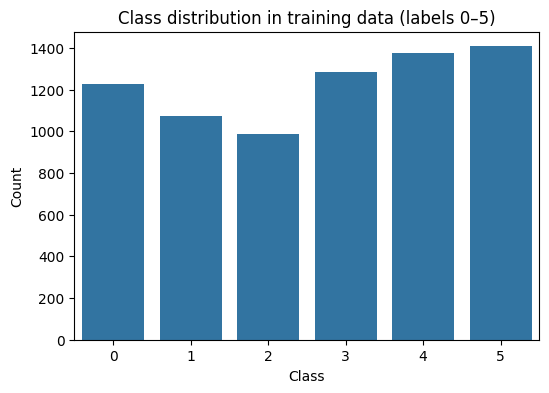

Feature summary (first 10 features):
1      tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  \
count       7.352000e+03       7.352000e+03       7.352000e+03   
mean       -3.131336e-16       4.783986e-17       8.698156e-17   
std         1.000068e+00       1.000068e+00       1.000068e+00   
min        -1.814049e+01      -2.407152e+01      -1.573085e+01   
25%        -1.638693e-01      -1.756427e-01      -2.092798e-01   
50%         3.850502e-02       1.167141e-02       8.206943e-03   
75%         1.988854e-01       1.693906e-01       2.003738e-01   
max         1.032661e+01       2.493878e+01       1.958529e+01   

1      tBodyAcc-std()-X  tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  \
count      7.352000e+03       7352.000000      7.352000e+03      7.352000e+03   
mean      -1.507680e-16          0.000000      2.938044e-16      3.865847e-17   
std        1.000068e+00          1.000068      1.000068e+00      1.000068e+00   
min       -8.793362e-01         -0.972792   

In [15]:
# ============================================
# 8. Exploratory data analysis (basic)
# ============================================

# Class distribution
plt.figure(figsize=(6,4))
sns.countplot(x=y_train)
plt.title("Class distribution in training data (labels 0–5)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# Feature statistics (summary)
print("Feature summary (first 10 features):")
print(pd.DataFrame(X_train_scaled, columns=features[1]).iloc[:, :10].describe())


In [16]:
# ============================================
# 9. Baseline Random Forest classifier
# ============================================
rf_base = RandomForestClassifier(random_state=42)
rf_base.fit(X_train_scaled, y_train)

rf_pred = rf_base.predict(X_test_scaled)

print("Baseline Random Forest Accuracy:",
      accuracy_score(y_test, rf_pred))
print("\nClassification Report (RF - baseline):\n",
      classification_report(y_test, rf_pred))


Baseline Random Forest Accuracy: 0.9260264675941635

Classification Report (RF - baseline):
               precision    recall  f1-score   support

           0       0.89      0.96      0.92       496
           1       0.89      0.90      0.90       471
           2       0.97      0.86      0.91       420
           3       0.91      0.89      0.90       491
           4       0.90      0.92      0.91       532
           5       1.00      1.00      1.00       537

    accuracy                           0.93      2947
   macro avg       0.93      0.92      0.92      2947
weighted avg       0.93      0.93      0.93      2947



In [17]:
# ============================================
# 10. Hyperparameter tuning for Random Forest
#     (RandomizedSearchCV for speed)
# ============================================
param_dist_rf = {
    "n_estimators": randint(100, 300),
    "max_depth": randint(5, 30),
    "min_samples_split": randint(2, 10),
    "min_samples_leaf": randint(1, 5)
}

rf_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_dist_rf,
    n_iter=15,
    cv=3,
    n_jobs=-1,
    verbose=1
)

rf_search.fit(X_train_scaled, y_train)

rf_best = rf_search.best_estimator_
rf_best_pred = rf_best.predict(X_test_scaled)

print("Best RF params:", rf_search.best_params_)
print("Tuned Random Forest Accuracy:",
      accuracy_score(y_test, rf_best_pred))
print("\nClassification Report (RF - tuned):\n",
      classification_report(y_test, rf_best_pred))


Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best RF params: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 7, 'n_estimators': 137}
Tuned Random Forest Accuracy: 0.9277231082456736

Classification Report (RF - tuned):
               precision    recall  f1-score   support

           0       0.88      0.97      0.92       496
           1       0.89      0.91      0.90       471
           2       0.96      0.83      0.89       420
           3       0.94      0.89      0.91       491
           4       0.90      0.95      0.92       532
           5       1.00      1.00      1.00       537

    accuracy                           0.93      2947
   macro avg       0.93      0.92      0.93      2947
weighted avg       0.93      0.93      0.93      2947



In [18]:
# ============================================
# 11. SVM classifier with basic tuning
# ============================================
param_dist_svm = {
    "C": [0.1, 1, 10],
    "gamma": ['scale', 0.01, 0.001],
    "kernel": ['rbf']
}

svm_search = RandomizedSearchCV(
    SVC(),
    param_distributions=param_dist_svm,
    n_iter=6,
    cv=3,
    n_jobs=-1,
    verbose=1
)

svm_search.fit(X_train_scaled, y_train)

svm_best = svm_search.best_estimator_
svm_pred = svm_best.predict(X_test_scaled)

print("Best SVM params:", svm_search.best_params_)
print("SVM Accuracy:", accuracy_score(y_test, svm_pred))
print("\nClassification Report (SVM):\n",
      classification_report(y_test, svm_pred))


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best SVM params: {'kernel': 'rbf', 'gamma': 0.001, 'C': 10}
SVM Accuracy: 0.9552086868001357

Classification Report (SVM):
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       496
           1       0.93      0.96      0.95       471
           2       0.98      0.93      0.95       420
           3       0.96      0.88      0.92       491
           4       0.91      0.97      0.94       532
           5       1.00      1.00      1.00       537

    accuracy                           0.96      2947
   macro avg       0.96      0.95      0.95      2947
weighted avg       0.96      0.96      0.96      2947



In [19]:
# ============================================
# 12. Neural Network (Dense model) in TensorFlow
# ============================================
model = models.Sequential([
    layers.Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(n_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train_scaled,
    y_train,
    epochs=15,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

dl_probs = model.predict(X_test_scaled)
dl_pred = dl_probs.argmax(axis=1)

print("Neural Network Accuracy:",
      accuracy_score(y_test, dl_pred))
print("\nClassification Report (Neural Net):\n",
      classification_report(y_test, dl_pred))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7018 - loss: 0.7663 - val_accuracy: 0.9239 - val_loss: 0.2173
Epoch 2/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9266 - loss: 0.1814 - val_accuracy: 0.9381 - val_loss: 0.1461
Epoch 3/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9538 - loss: 0.1216 - val_accuracy: 0.9232 - val_loss: 0.2381
Epoch 4/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9595 - loss: 0.0984 - val_accuracy: 0.9347 - val_loss: 0.2023
Epoch 5/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9726 - loss: 0.0694 - val_accuracy: 0.9334 - val_loss: 0.1809
Epoch 6/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9720 - loss: 0.0796 - val_accuracy: 0.9347 - val_loss: 0.2000
Epoch 7/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9780 - loss: 0.0600 - val_accuracy: 0.9307 - val_loss: 0.2943
Epoch 8/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9752 - loss: 0.0613 - val_accuracy: 0

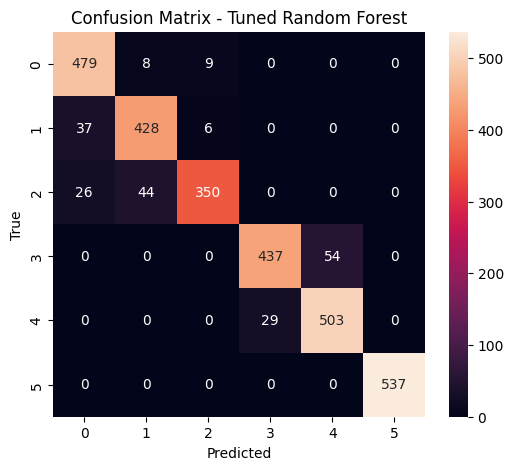

In [20]:
# ============================================
# 13. Plot confusion matrix (for best model)
#     Here we use tuned Random Forest
# ============================================
cm = confusion_matrix(y_test, rf_best_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='g')
plt.title("Confusion Matrix - Tuned Random Forest")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


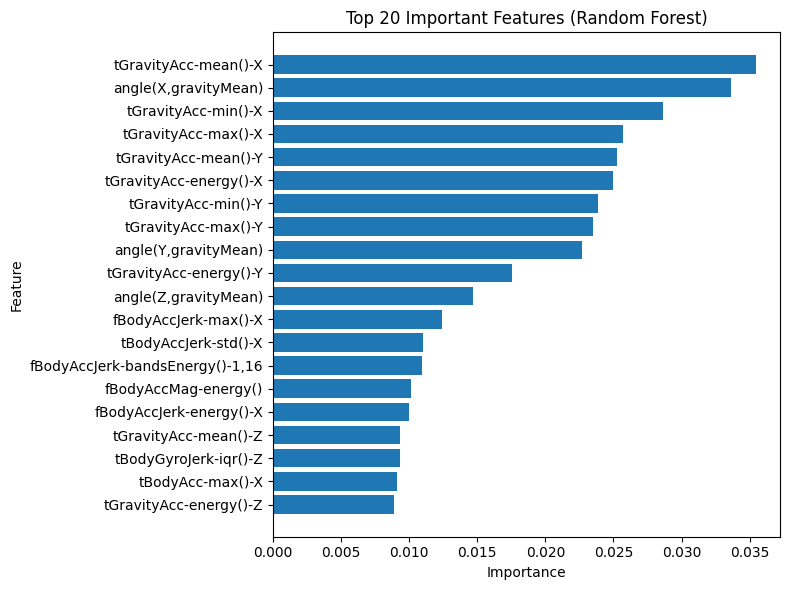

In [21]:
# ============================================
# 14. Feature importance (Random Forest)
# ============================================
importances = rf_best.feature_importances_
indices = np.argsort(importances)[-20:]   # top 20 features

plt.figure(figsize=(8,6))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [features[1][i] for i in indices])
plt.title("Top 20 Important Features (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [22]:
# ============================================
# 15. Save models and scaler
# ============================================
joblib.dump(rf_best, "har_rf_best.pkl")
joblib.dump(svm_best, "har_svm_best.pkl")
joblib.dump(scaler, "har_scaler.pkl")
model.save("har_nn_model.h5")

print("Models and scaler saved.")


Models and scaler saved.


In [23]:
# ============================================
# 16. Example prediction on one sample
# ============================================
sample = X_test_scaled[10].reshape(1, -1)

rf_sample_pred = rf_best.predict(sample)[0]
svm_sample_pred = svm_best.predict(sample)[0]
nn_sample_pred = model.predict(sample).argmax(axis=1)[0]

def label_to_name(label_zero_based):
    # dataset original labels are 1–6; we subtracted 1 earlier
    original_label = label_zero_based + 1
    return activity_labels.loc[original_label].values[0]

print("True label:", label_to_name(y_test.iloc[10]))
print("RF prediction:", label_to_name(rf_sample_pred))
print("SVM prediction:", label_to_name(svm_sample_pred))
print("NN prediction:", label_to_name(nn_sample_pred))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
True label: STANDING
RF prediction: STANDING
SVM prediction: STANDING
NN prediction: STANDING


In [24]:
from sklearn.metrics import accuracy_score

rf_accuracy = accuracy_score(y_test, rf_best_pred) * 100
svm_accuracy = accuracy_score(y_test, svm_pred) * 100
nn_accuracy = accuracy_score(y_test, dl_pred) * 100

print("📌 Final Model Accuracy Summary")
print("--------------------------------")
print(f"Random Forest Accuracy     : {rf_accuracy:.2f}%")
print(f"SVM Accuracy               : {svm_accuracy:.2f}%")
print(f"Neural Network Accuracy    : {nn_accuracy:.2f}%")

best_model_accuracy = max(rf_accuracy, svm_accuracy, nn_accuracy)

print("\n🏆 Best Model Accuracy:", f"{best_model_accuracy:.2f}%")


📌 Final Model Accuracy Summary
--------------------------------
Random Forest Accuracy     : 92.77%
SVM Accuracy               : 95.52%
Neural Network Accuracy    : 92.94%

🏆 Best Model Accuracy: 95.52%
